# Singapore 6-Hourly Rainfall Forecast

### Note that for simplicity, some code is not run in this notebook. Particularly, scraping and evaluation is conducted outside.

In this exercise, I try to predict total rainfall in 6-hour blocks. Given the weather variables observed at the start of each 6-hour period (including wind speed, air temperature, humidity etc.), I try to predict the total rainfall that will occur in the coming 6 hours. To do this, data is retrieved from the APIs available at data.gov.sg. Using this data, I create a stacked regression model to attempt this forecast.

Our response variable in this case is the rainfall variable which has 54 sensors islandwide. For other variables however, there are lesser sensors. For each rainfall station, the nearest sensor of each type is found and the reading in that station is used for prediction.

In [1]:
import pickle
import requests
import pandas as pd
from scipy.spatial.distance import euclidean
import datetime
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import lightgbm as lgb
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from IPython.display import Image

D:\OneDrive\WinPython-64bit-3.5.4.0Qt5\python-3.5.4.amd64\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Each entry is contains all sensor data for each point in time. Note that for some variables, there are lesser stations island wide. We need to define functions that allow us to find the nearest stations at each point.

In [2]:
def nearestStation(loc, locList):
    if len(locList) == 0:
        return 'NoStation'
    l = sorted([(entry[0], euclidean(loc,(entry[1],entry[2]))) for entry in locList], key = lambda d: d[1])
    return l[0][0]

def findNearestStation(x):
    windspeed_locs = [(entry['id'],
                       entry['location']['latitude'],
                      entry['location']['longitude']) for entry in x['wind-speed']['metadata']['stations']] 
        
    airtemp_locs = [(entry['id'],
                       entry['location']['latitude'],
                      entry['location']['longitude']) for entry in x['air-temperature']['metadata']['stations']]
        
    rainfall_locs = [(entry['id'],
                       entry['location']['latitude'],
                      entry['location']['longitude']) for entry in x['rainfall']['metadata']['stations']]    
        
    winddir_locs = [(entry['id'],
                       entry['location']['latitude'],
                      entry['location']['longitude']) for entry in x['wind-direction']['metadata']['stations']]     
        
    humidity_locs = [(entry['id'],
                       entry['location']['latitude'],
                      entry['location']['longitude']) for entry in x['relative-humidity']['metadata']['stations']]     
        
    pm25_locs = [(entry['name'], entry['label_location']['latitude'], entry['label_location']['longitude'])for entry in x['pm25']['region_metadata']]
    
    locations = [windspeed_locs, airtemp_locs, rainfall_locs, winddir_locs, humidity_locs, pm25_locs]
    nearest = {station[0]: [nearestStation(station[1:3], locList) for locList in locations] for station in rainfall_locs}
    
    return nearest

We begin by defining a few functions that will help us access the API. The first function pulls from the data.gov.sg API.

The second function converts a list of JSON files called from calldata into a pandas DataFrame.

In [3]:
def calldata(date_time, api_key, resource_list):
    params = {'date_time': date_time}
    headers = {
                'api-key': api_key,
                'accept' : 'application/json'
               }
    x = {url.split('/')[-1]: requests.get(url, headers = headers, params = params).json() for url in resource_list}
    return x

def toDataFrame(x):
    d, t = x['rainfall']['items'][0]['timestamp'] .split('T')
    print(d,t)
    values = {}
    values['rainfall'] =  {item['station_id']: item['value'] for item in x['rainfall']['items'][0]['readings']}    
    values['windspeed'] = {item['station_id']: item['value'] for item in x['wind-speed']['items'][0]['readings']}
    values['airtemp'] =  {item['station_id']: item['value'] for item in x['air-temperature']['items'][0]['readings']}
    try:
        values['pm25'] = x['pm25']['items'][0]['readings']['pm25_one_hourly'] #central east north south west, dict
    except:
        values['pm25'] = {'NoStation': np.nan}
    
    values['humidity'] = {item['station_id']: item['value'] for item in x['relative-humidity']['items'][0]['readings']}
    values['winddir'] =  {item['station_id']: item['value'] for item in x['wind-direction']['items'][0]['readings']}
    
    try:
        psi = x['psi']['items'][0]['readings']
        psi_cols = list(psi.keys())
        values = {**values, **psi} #Many types of readings, loop into key/value pairs, central east north south west national
        nearest = findNearestStation(x)
        attr = pd.DataFrame.from_dict(nearest, orient='index')
        attr.columns = ['windspeed', 'airtemp', 'rainfall', 'winddir', 'humidity', 'pm25']
    
        for col in psi_cols:
            attr[col] = attr['pm25']
    except:
        print('No psi readings')
        nearest = findNearestStation(x)
        attr = pd.DataFrame.from_dict(nearest, orient='index')
        attr.columns = ['windspeed', 'airtemp', 'rainfall', 'winddir', 'humidity', 'pm25']

        
    for v in values:
        attr[v] = [values[v][i] for i in attr[v]]
    attr['datestamp'] = d + '/' + str(np.floor(int(t.split(':')[0])/6))     
    return attr

#### Create a wrapper to pull data from all dates required

In [4]:
def scraper(datestart, dateend, api_key, resourcelist, by = {'day': 1}):
    datelabels = []
    response = []
    Datestart = datetime.datetime.strptime(datestart, '%Y-%m-%d')
    Dateend = datetime.datetime.strptime(dateend, '%Y-%m-%d')
    while Datestart < Dateend:
        print(Datestart)
        datelabels.append(Datestart)
        r = calldata(Datestart.isoformat(), api_key, resourcelist)
        response.append(r)
        Datestart += datetime.timedelta(**by)
    
    return response

#### Begin scraping data

In [ ]:
resourcelist = ['https://api.data.gov.sg/v1/environment/wind-speed',
               'https://api.data.gov.sg/v1/environment/air-temperature',
               'https://api.data.gov.sg/v1/environment/pm25',
               'https://api.data.gov.sg/v1/environment/psi',
               'https://api.data.gov.sg/v1/environment/rainfall',
               'https://api.data.gov.sg/v1/environment/relative-humidity',
               'https://api.data.gov.sg/v1/environment/wind-direction'
               ]
api_key = 'API Key Here'

datestart = '2017-07-15'
dateend = '2017-09-15'
response = scraper(datestart, dateend, api_key, resourcelist)

In [5]:
response = pickle.load(open('response.p', 'rb'))
print(response[0])

{'relative-humidity': {'metadata': {'reading_type': 'RH 1M F', 'reading_unit': 'percentage', 'stations': [{'device_id': 'S109', 'name': 'Ang Mo Kio Avenue 5', 'id': 'S109', 'location': {'latitude': 1.3764, 'longitude': 103.8492}}, {'device_id': 'S117', 'name': 'Banyan Road', 'id': 'S117', 'location': {'latitude': 1.256, 'longitude': 103.679}}, {'device_id': 'S107', 'name': 'East Coast Parkway', 'id': 'S107', 'location': {'latitude': 1.3135, 'longitude': 103.9625}}, {'device_id': 'S43', 'name': 'Kim Chuan Road', 'id': 'S43', 'location': {'latitude': 1.3399, 'longitude': 103.8878}}, {'device_id': 'S108', 'name': 'Marina Gardens Drive', 'id': 'S108', 'location': {'latitude': 1.2799, 'longitude': 103.8703}}, {'device_id': 'S06', 'name': 'S06', 'id': 'S06', 'location': {'latitude': 1.3524, 'longitude': 103.9007}}, {'device_id': 'S102', 'name': 'Semakau Landfill', 'id': 'S102', 'location': {'latitude': 1.189, 'longitude': 103.768}}, {'device_id': 'S96', 'name': 'Tanah Merah Coast Road', 'id'

The value for rainfall at each point in time is the rainfall in that hour. Since data is only scraped in 6-hour intervals, we need to collect more data for rainfall, in 1-hour intervals

In [6]:
def rainDataFrame(x):
    d, t = x['rainfall']['items'][0]['timestamp'] .split('T')
    print(d)
    values = {}
    values['rainfall'] =  {item['station_id']: item['value'] for item in x['rainfall']['items'][0]['readings']}    
    attr = pd.DataFrame(list(values['rainfall'].items()), columns = ['SID','rainfall'])
    
    attr['datestamp'] = d + '/' + str(np.floor(int(t.split(':')[0])/6))
    return attr

Now start collecting rainfall data. After collection, the data is summed into 6 hour intervals.

In [ ]:
dateend = '2017-01-15'
rainfall =  scraper(datestart, dateend, api_key, resourcelist =['https://api.data.gov.sg/v1/environment/rainfall'], by = {'hours': 1})
rain = pd.concat(rainfall)
rain = rain.groupby(['SID','datestamp']).sum().groupby(['SID','datestamp']).sum()
raining = [rain]

for i in range(2,9):
    datestart = '2017-0{}-15'.format(i)
    dateend = '2017-0{}-15'.format(i+1)
    rainfall = scraper(datestart, dateend, api_key, resourcelist =['https://api.data.gov.sg/v1/environment/rainfall'], by = {'hours': 1})
    rain = pd.concat([rainDataFrame(x) for x in rainfall])
    rain = rain.groupby(['SID','datestamp']).sum().groupby(['SID','datestamp']).sum()
    raining.append(rainfall)tamp'] = d + '/' + str(np.floor(int(t.split(':')[0])/6))

Both rain and other variables are combined into a single dataframe, joined on StationID and date/time.

In [ ]:
Rain = pd.concat(raining)
pickle.dump(Rain, open('rain.p', 'wb'))

d = [toDataFrame(x) for x in response]
df = pd.concat(d)
df.drop('rainfall', axis = 1, inplace=True)
df['SID'] = df.index
Rain['SID'] = Rain.index.droplevel(1)
Rain['datestamp'] = Rain.index.droplevel(0)
df = df.merge(Rain, on = ['SID','datestamp'])

## Training and Evaluattion

We begin by defining a function that will help to replace missing values. Next, we create a wrapper that helps with cross validation for fine tuning models

In [7]:
def stripNA (vec, replace = 0, fun = np.nanmean, cts = False):
    if cts:
        r = fun(vec)
    else:
        r = replace 
    g = vec.apply(lambda x: r if np.isnan(x) else x)
    return g


def evaluate(vec, label):
    return np.sqrt(np.mean((vec-label)**2))

#def trainer(fun, X_train, X_test, y_train, y_test, params={}):
#    rgr = fun(**params)
#    rgr.fit(X_train, y_train)
#    prediction = rgr.predict(X_test)
#    score = evaluate(prediction, y_test)
    
    return score
def validator(estimator, param_grid, X, Y):
    clf = GridSearchCV(estimator, param_grid)
    clf.fit(X,Y)
    print(clf.best_params_)
    print(clf.best_score_)
    return clf

### Architecture
The model used in this attempt at prediction is a stacked model.

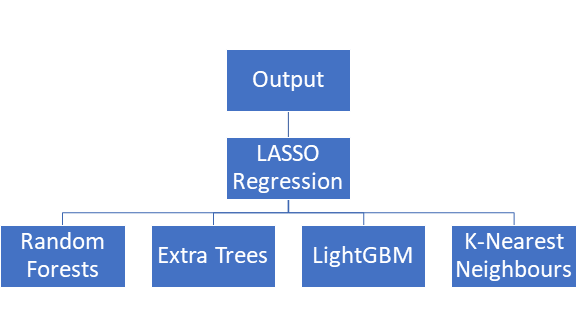

In [9]:
Image("architecture.png")

The bottom level contains a Random Forest model, Extra Trees model, Gradient Boosted Tree and a K-Nearest Neighbours model. The results of these models are fed into a LASSO regression that generates the final output.

### Trainer
The following is the workhorse for the model, it is designed to be easy to interface with, requiring as little input as possible from a users perspective. In includes methods that help with training various single-level model as well as training the overall 2-level model. Training cross-validation for fine-tuning as well as fitting each individual model.

The class also aids generating predictions and evaluating performance of the model(s).

In [8]:
class EnsembleTrainer:
    def __init__(self, l1models, l2model, param_grids = None):
        
        self.l1models = l1models
        self.l2model = l2model
        
    def tunel1(self, data, labels, param_grids):
        self.y_train = labels
        
        self.tunedModels = []
        for i in range(len(self.l1models)):
            self.tunedModels.append(validator(self.l1models[i](), param_grids[i], data, labels))    
            print('Trained model' + str(i))
        
        self.l1score = [model.best_score_ for model in self.tunedModels]
        
        ed = [model.predict(data) for model in self.tunedModels]
        self.l1TOutput = np.array(ed).transpose()
        
    def definel1(self, data, labels, param_grids):
        self.y_train = labels
        
        self.tunedModels = []
        for i in range(len(self.l1models)):
            self.tunedModels.append(self.l1models[i](**param_grids[i]))
            
        for model in self.tunedModels:
            model.fit(data, labels)
            print('Trained')
        
        print('Making l1 Predictions')
        ed = [model.predict(data) for model in self.tunedModels]
        self.l1TOutput = np.array(ed).transpose()
        
    def predictl1(self, data):
        ed = [model.predict(data) for model in self.tunedModels]
        self.l1Output = np.array(ed).transpose()
        
        
    def tunel2(self, param_grid):
        self.tunedl2 = validator(self.l2model(), param_grid, self.l1TOutput, self.y_train)
        self.l2score = self.tunedl2.best_score_
        self.tunedl2.fit(self.l1TOutput, self.y_train)
        
    def definel2(self, param_grid):
        self.tunedl2 = self.l2model(**param_grid)
        self.tunedl2.fit(self.l1TOutput, self.y_train)
        
    def predictl2(self):
        self.l2Output = self.tunedl2.predict(self.l1Output)
        
    def fit(self, X_train, Y_train, param_gridsl1, param_gridsl2, tune = True):
        if tune:
            self.tunel1(X_train, Y_train, param_gridsl1)
            self.tunel2(param_gridsl2)
        else:
            self.definel1(X_train,Y_train, param_gridsl1)
            self.definel2(param_gridsl2)

    def predict(self, X_test):
        self.predictl1(X_test)
        self.predictl2()
        
    def evaluatel2(self, Y_test):
        return metrics.mean_squared_error(self.l2Output, Y_test)
        
    def evaluatel1(self, Y_test):
        return np.apply_along_axis(metrics.mean_squared_error, 0, self.l1Output, Y_test)

Now we prepare the data for analysis by removing the appropriate columns, replacing missing data and defining the variables and labels.

In [21]:
df = pickle.load(open('dataarray.p','rb'))
X = df.drop(['rainfall','datestamp','SID'], axis = 1)
X = preprocessing.scale(X.apply(stripNA, axis = 0, cts=True).values)

Y = df.sum(axis=1).values
Y = df['rainfall'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=1)

The next step is fine tuning the hyperparameters of each individual model. In the next cell, the search parameters are defined. Due to constraints on time and computing power, the search grid has been limited.

In [10]:
tree_grid = {
        'max_features': [5, X.shape[1]],
        'n_estimators': [10, 100, 10],
        'max_leaf_nodes': [2,100,5]
}

knn_grid = {
        'n_neighbors': [5, X.shape[0], 1000],
}

lgb_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

lasso_grid = {
        'alpha': [0,1,0.1],
}
param_grids = [tree_grid, tree_grid, knn_grid, lgb_grid]


In [ ]:
#NOTE: Fine tuning was conducted outside of this notebook, parameters were saved and will be used to define models later
ET = EnsembleTrainer([RandomForestRegressor, ExtraTreesRegressor, lgb.LGBMRegressor], Lasso) #, KNeighborsRegressor
ET.fit(X_train, y_train, param_grids, lasso_grid, tune=True)
ET.predict(X_test)
ET.evaluatel1(y_test)
ET.evaluatel2(y_test)

When .fit is called with tune=True, each model is cross-validated using the specified search grid. As fine-tuning requires a long time and was conducted outside of this notebook, the fine-tuned hyperparameters are called below instead, with tune set to False.

In [22]:
tree_grid = {
        'max_features': 5,
        'n_estimators': 100,
        'max_leaf_nodes': 100
}

knn_grid = {
        'n_neighbors': 3000,
}

lgb_grid = {
    'learning_rate': 0.4,
    'n_estimators': 35
}

lasso_grid = {
        'alpha': 0.4
}
param_grids = [tree_grid, tree_grid, knn_grid, lgb_grid] 

In [23]:
ET = EnsembleTrainer([RandomForestRegressor, ExtraTreesRegressor, KNeighborsRegressor, lgb.LGBMRegressor], Lasso) #, KNeighborsRegressor
ET.fit(X_train, y_train, param_grids, lasso_grid, tune=False)
ET.predict(X_test)

Trained
Trained
Trained
Trained
Making l1 Predictions


With the cell above, the model is trained and predictions are generated on the test set. The expected out-of-sample performance is shown below.

In [24]:
print(ET.evaluatel1(y_test))
print(ET.evaluatel2(y_test))

[ 2.08079247  2.21755589  2.64874536  1.83790317]
1.84114443616


The evaluation metric used in Mean Squared Error. 

In [27]:
ET.l2Output - y_test

array([ 0.04449972,  0.07468904,  0.08432008, ...,  0.26054625,
        0.06456441,  0.03934263])

While performance in this model is decent, the results could be greatly improved given more time. Collecting historical data through the data.gov.sg API requires a lot of time; collecting 9 months worth of rainfall data took roughly 8 hours, the other variables took roughly 2 hours.

Furthermore, cross-validation required a lot of time as well, limiting the feasible search grid. With more time, the parameters could be further fine tuned and other parameters adjusted as well. 

As we see from the output, rain (albeit a small amount) is predicted at almost every time interval. An alternative to using regression techniques would be to use classification techniques to determine the presence of rain (rainfall > 0.0mm) instead. However, this would deny the user information on the amount of rain.